In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler

<div style="background-color: lightpink; padding: 10px;">
    <p> The Supermarket Sales dataset from Kaggle contains transactional data for a supermarket chain, including the date of purchase, branch, customer type, and sales amount. For time series forecasting, we can focus on predicting sales over time, aggregated by date.</p>
    <p style="margin: 0;">Employing ARIMA, LSTM, and Prophet to swiftly evaluate the performance of these three forecasting models on this dataset.</p>
</div>

In [21]:
# Load dataset
data = pd.read_csv('supermarket_sales.csv')
data.head(3)

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4


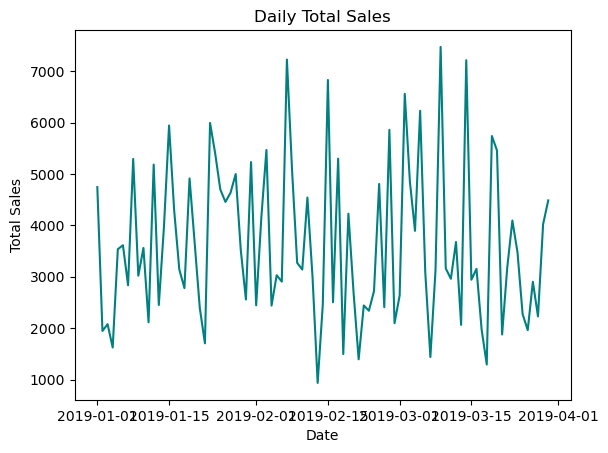

In [25]:
# Load dataset
data = pd.read_csv('supermarket_sales.csv')
data['Date'] = pd.to_datetime(data['Date'])

# Selecting only Date and Total sales amount for simplicity
data = data[['Date', 'Total']]

# Aggregating total sales per day as some rows show the same day, different hour
data = data.groupby('Date').sum().reset_index()

# Plot data
plt.plot(data['Date'], data['Total'], color='teal')
plt.title('Daily Total Sales')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

## ARIMA

C:\Users\thesk\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


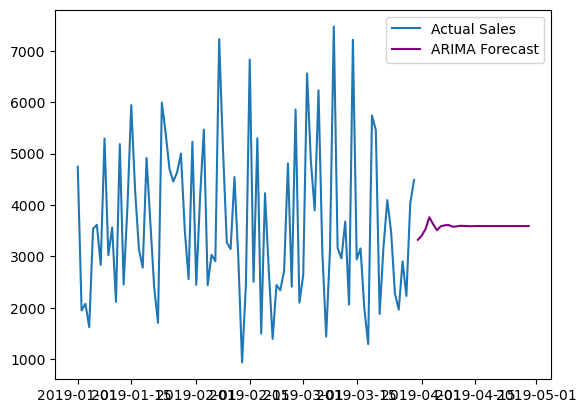

In [26]:
# Set the date as index for ARIMA model
data.set_index('Date', inplace=True)
data.index.freq = 'D'  # Set the frequency to daily

# Fit ARIMA model
arima_model = ARIMA(data['Total'], order=(5, 1, 2))  # Adjust order as needed
arima_result = arima_model.fit()

# Forecast next 30 days
arima_forecast = arima_result.forecast(steps=30)
plt.plot(data.index, data['Total'], label="Actual Sales")
plt.plot(pd.date_range(data.index[-1], periods=31, freq='D')[1:], arima_forecast, label="ARIMA Forecast", color='purple')
plt.legend()
plt.show()

Arime Forecast failed to merge, it needs a lot of parameter adjusting. My order was=(5, 1, 2) to use the previous 5 observations, to difference data once to make it stationary, and to use the previous 2 forecast errors. I could use Auto Arime, a method which automatically selects the best ARIMA model parameters (p, d, q) by optimizing for a given information criterion (like AIC or BIC). I need to instal pmdarima library which provides an auto_arima function but let's explore two other forecasters.

## LSTM

Epoch 1/10
59/59 [==============================] - 7s 16ms/step - loss: 0.0917
Epoch 2/10
59/59 [==============================] - 1s 17ms/step - loss: 0.0689
Epoch 3/10
59/59 [==============================] - 1s 16ms/step - loss: 0.0664
Epoch 4/10
59/59 [==============================] - 1s 16ms/step - loss: 0.0726
Epoch 5/10
59/59 [==============================] - 1s 15ms/step - loss: 0.0649
Epoch 6/10
59/59 [==============================] - 1s 16ms/step - loss: 0.0620
Epoch 7/10
59/59 [==============================] - 1s 16ms/step - loss: 0.0682
Epoch 8/10
59/59 [==============================] - 1s 16ms/step - loss: 0.0655
Epoch 9/10
59/59 [==============================] - 1s 16ms/step - loss: 0.0664
Epoch 10/10
59/59 [==============================] - 1s 16ms/step - loss: 0.0645


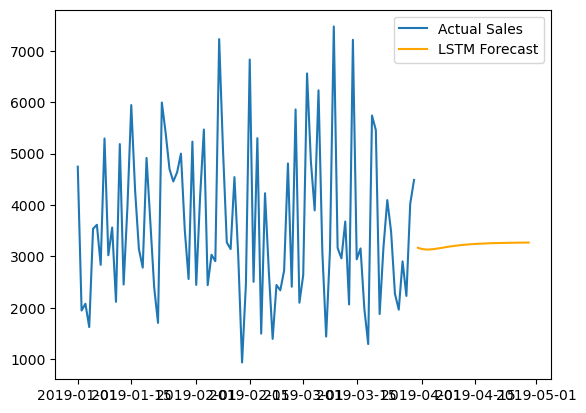

In [4]:
# Load dataset
df = pd.read_csv('supermarket_sales.csv')
df['Date'] = pd.to_datetime(df['Date'])
data = df[['Date', 'Total']].groupby('Date').sum().reset_index()

# Setting up the data for LSTM with basic scaling
data.set_index('Date', inplace=True)

# Apply MinMax scaling to the sales data (0-1 range)
scaler = MinMaxScaler()
data['Total_scaled'] = scaler.fit_transform(data[['Total']])

# Prepare data for LSTM
window_size = 30
X, y = [], []
for i in range(window_size, len(data)):
    X.append(data['Total_scaled'].values[i-window_size:i])
    y.append(data['Total_scaled'].values[i])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Build and train the LSTM model
model = Sequential([
    LSTM(units=50, input_shape=(X.shape[1], 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X, y, epochs=10, batch_size=1, verbose=1)

# Forecast next 30 days
predictions = []
input_data = X[-1]  # Start with the last window of data in the training set

for _ in range(30):
    prediction = model.predict(np.array([input_data]), verbose=0)
    predictions.append(prediction[0, 0])
    input_data = np.roll(input_data, -1)
    input_data[-1] = prediction

# Inverse scaling for predictions
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Plot results
plt.plot(data.index, data['Total'], label="Actual Sales")
plt.plot(pd.date_range(data.index[-1], periods=31, freq='D')[1:], predictions, label="LSTM Forecast", color="orange")
plt.legend()
plt.show()

It seems that the LSMT Forecast did not capture the data's variability too well. It needed to scale the data (without scaling all predictions were 0) and need to experiment more with different sequence lengths, LSTM units, and epochs to see if these adjustments help capture it.

## Prophet

20:25:44 - cmdstanpy - INFO - Chain [1] start processing
20:25:44 - cmdstanpy - INFO - Chain [1] done processing


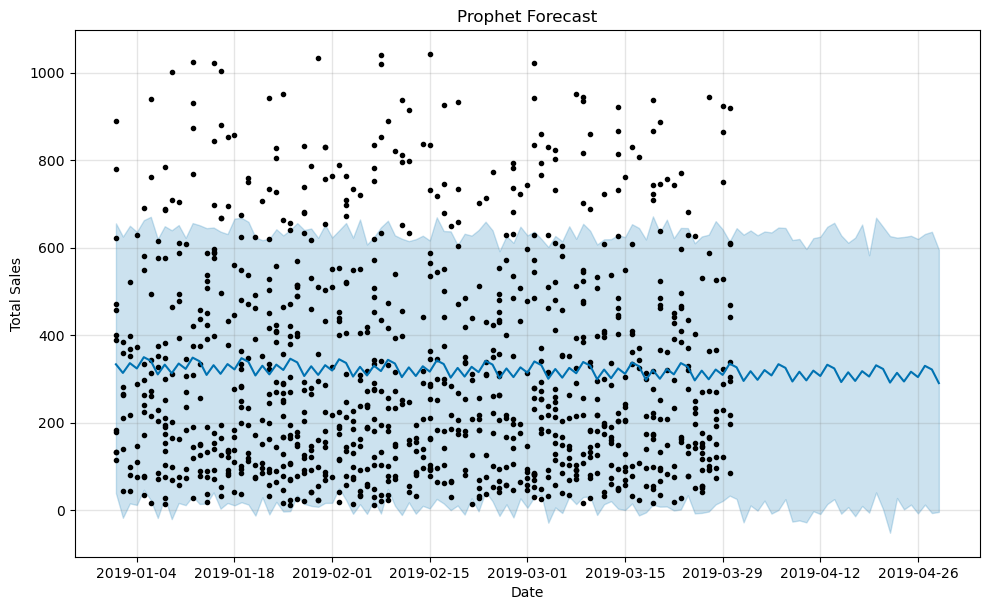

In [2]:
# Load dataset
data = pd.read_csv('supermarket_sales.csv')
data['Date'] = pd.to_datetime(data['Date'])

# Selecting only Date and Total sales amount for simplicity
data = data[['Date', 'Total']]

# Prepare data for Prophet
prophet_data = data.rename(columns={'Date': 'ds', 'Total': 'y'})

# Fit Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_data)

# Make future predictions
future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)

# Plot results
prophet_model.plot(forecast)
plt.title("Prophet Forecast")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.show()

The flat forecast (without an obvious upward or downward trend) may indicate that Prophet didn’t detect a strong seasonal or growth trend in the dataset. This could happen if the historical data is noisy or if the time period is too short to capture seasonal effects. Light blue - 80% confidence interval. Adding holiday effects or other regressors (like special events or promotions) could potentially improve accuracy if such information is relevant.